In [1]:
import wradlib as wrl
import wradlib
import pcc
import satlib 
from satlib import good_overpasses_dpr_boxpol as overpasses_dpr_boxpol
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline


In [2]:

# Wichtige Parameter festlegen
TH = 15 #Threshold um Nullen fuer Niederschlag raus zu filtern


#################################################### PPI BoxPol Daten einlesen
#------------------------------------------------------------------------------
data, attrs = wradlib.io.read_gamic_hdf5("/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_1p5deg/2014-10-07--02:37:44,00.mvol")

## Polarimetrischen momente
# Ref Horizontal
ZH = data['SCAN0']['ZH']['data']
ZH_RAW = ZH.copy()
# Zdr
ZDR = data['SCAN0']['ZDR']['data']

#PhiDP
PHIDP = data['SCAN0']['PHIDP']['data']

# KDP
KDP = data['SCAN0']['KDP']['data']

#RhoHV
RHOHV = data['SCAN0']['RHOHV']['data']

# Radius
r = attrs['SCAN0']['r']

#  Azimuth
az = attrs['SCAN0']['az']

# Elevation
elevation=attrs['SCAN0']['elevation']

# Longitude
lon_ppi = attrs['VOL']['Longitude']

# Latitude
lat_ppi = attrs['VOL']['Latitude']

# Altitude
alt_ppi = attrs['VOL']['Height']



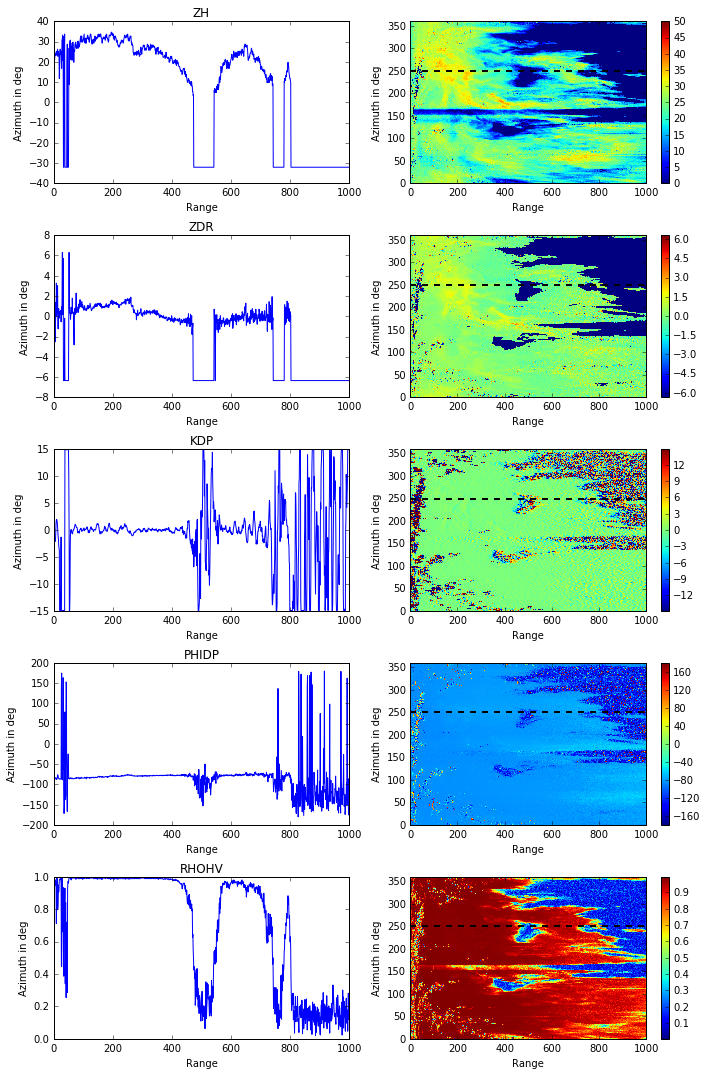

In [3]:
cut = 250
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.plot(ZH[cut,:])
plt.title('ZH')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,2)
plt.pcolormesh(ZH, vmin=0, vmax=50)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,3)
plt.plot(ZDR[cut,:])
plt.title('ZDR')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,4)
plt.pcolormesh(ZDR)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,5)
plt.plot(KDP[cut,:])
plt.title('KDP')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,6)
plt.pcolormesh(KDP)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,7)
plt.plot(PHIDP[cut,:])
plt.title('PHIDP')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,8)
plt.pcolormesh(PHIDP)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,9)
plt.plot(RHOHV[cut,:])
plt.title('RHOHV')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,10)
plt.pcolormesh(RHOHV)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.tight_layout()

In [4]:
np.median(PHIDP[:,0:30])  # PHIDP oFFSet?!?!?

-84.40796

# Inner Outer Data
-----------------------------------



In [5]:
# Removing inner and outer Ring
in_r, ou_r = 6000, 90000
ZH[:,np.where(r<in_r)]=np.nan
ZH[:,np.where(r>ou_r)]=np.nan

ZDR[:,np.where(r<in_r)]=np.nan
ZDR[:,np.where(r>ou_r)]=np.nan

RHOHV[:,np.where(r<in_r)]=np.nan
RHOHV[:,np.where(r>ou_r)]=np.nan

KDP[:,np.where(r<in_r)]=np.nan
KDP[:,np.where(r>ou_r)]=np.nan

PHIDP[:,np.where(r<in_r)]=np.nan
PHIDP[:,np.where(r>ou_r)]=np.nan

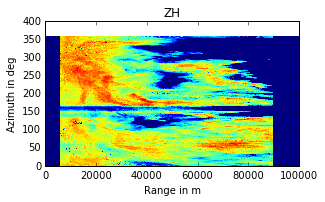

In [6]:
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.pcolormesh(r,az,ZH, vmin=0, vmax=40)
plt.title('ZH')
plt.xlabel('Range in m')
plt.ylabel('Azimuth in deg')


# Smoothe Data
--------------

In [7]:
#### Smothen mit roing median
window = 9
window2 = 51
ww = 151

phidp = PHIDP.copy()

min_periods  = 2
ZH = pd.rolling_median(ZH, window2, min_periods ,center=True, how='median', axis=1)
ZDR = pd.rolling_median(ZDR, window2, min_periods ,center=True, how='median')
PHIDP = pd.rolling_median(PHIDP, window2, min_periods ,center=True, how='median')
PHIDP2 = pd.rolling_median(PHIDP, ww, min_periods ,center=True, how='mean')
PHIDP3 = pd.rolling_median(PHIDP, window, min_periods ,center=True, how='mean')

KDP = pd.rolling_median(KDP, window2, min_periods ,center=True, how='median')
RHOHV = pd.rolling_median(RHOHV, window2, min_periods ,center=True, how='median')


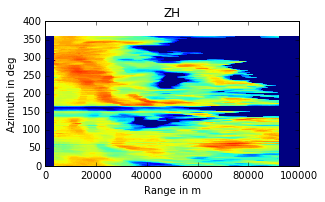

In [8]:
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.pcolormesh(r,az,ZH, vmin=0, vmax=40)
plt.title('ZH')
plt.xlabel('Range in m')
plt.ylabel('Azimuth in deg')


# Beamblockage
------------------------------------

# Clutter and Echo Classification
-------------------------------------------------------

In [9]:
clmap = wrl.clutter.filter_gabella(ZH,
                               wsize=5,
                               thrsnorain=0.,
                               tr1=6.,
                               n_p=8,
                               tr2=1.3)



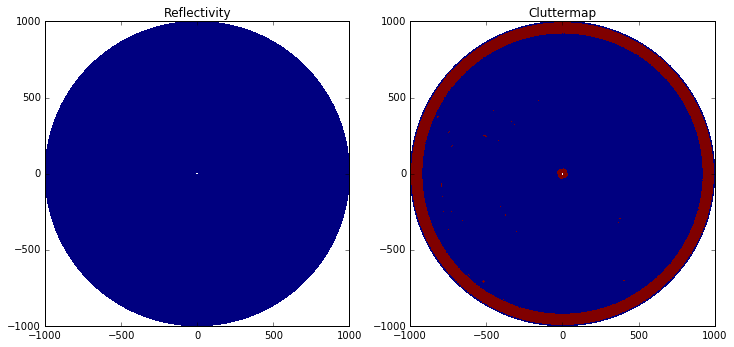

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax, pm = wrl.vis.plot_ppi(ZH, ax=ax)
ax.set_title('Reflectivity')
ax = fig.add_subplot(122)
ax, pm = wrl.vis.plot_ppi(clmap, ax=ax)
ax.set_title('Cluttermap')

In [11]:
ZH[clmap==True]=np.nan

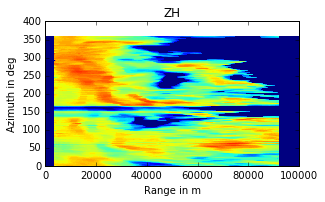

In [12]:
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.pcolormesh(r,az,ZH, vmin=0, vmax=40)
plt.title('ZH')
plt.xlabel('Range in m')
plt.ylabel('Azimuth in deg')

In [13]:
ZH[RHOHV<0.9]=np.nan

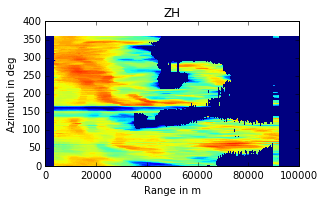

In [14]:
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.pcolormesh(r,az,ZH, vmin=0, vmax=40)
plt.title('ZH')
plt.xlabel('Range in m')
plt.ylabel('Azimuth in deg')

# Calibration
------------------------
?????

Ofset 2 ??? Klar doch :D

# Attenuation Correction
-----------------------------------



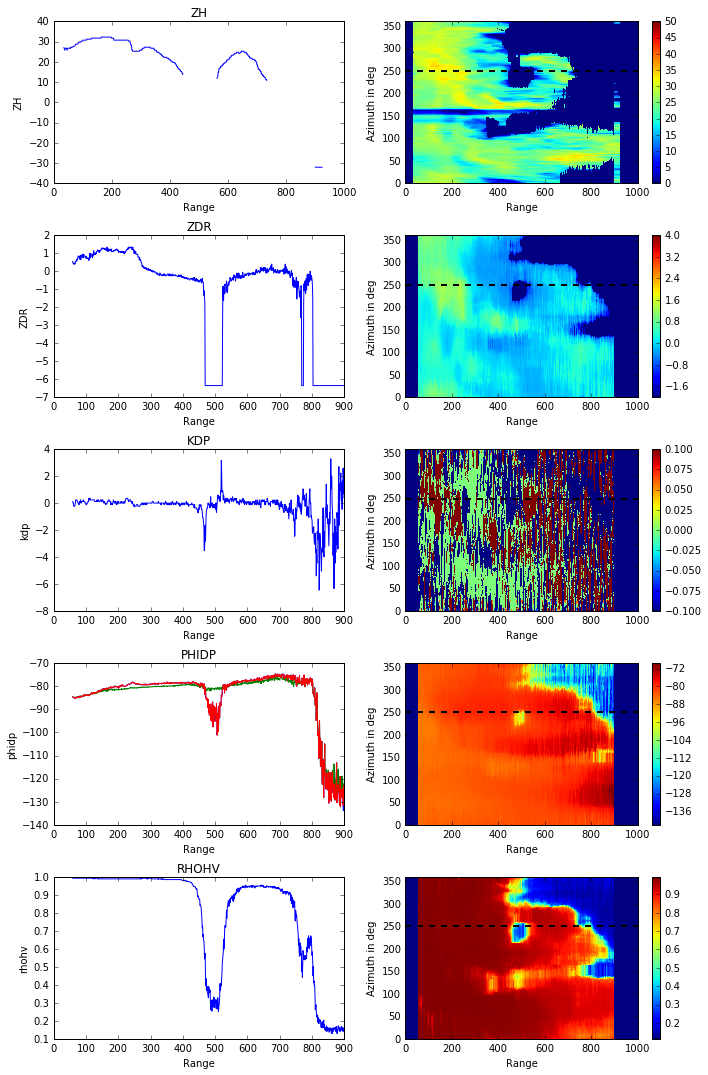

In [15]:
plt.figure(figsize=(10,15))
plt.subplot(5,2,1)
plt.plot(ZH[cut,:])
plt.title('ZH')
plt.xlabel('Range')
plt.ylabel('ZH')

plt.subplot(5,2,2)
plt.pcolormesh(ZH, vmin=0, vmax=50)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,3)
plt.plot(ZDR[cut,:])
plt.title('ZDR')
plt.xlabel('Range')
plt.ylabel('ZDR')

plt.subplot(5,2,4)
plt.pcolormesh(ZDR, vmin=-2, vmax=4)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,5)
plt.plot(KDP[cut,:])
plt.title('KDP')
plt.xlabel('Range')
plt.ylabel('kdp')

plt.subplot(5,2,6)
plt.pcolormesh(KDP)
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,7)
plt.plot(PHIDP[cut,:])
plt.plot(PHIDP2[cut,:])
plt.plot(PHIDP3[cut,:], color='red')

plt.title('PHIDP')
plt.xlabel('Range')
plt.ylabel('phidp')

plt.subplot(5,2,8)
plt.pcolormesh(PHIDP, vmin=np.nanmin(PHIDP), vmax=np.nanmax(PHIDP))
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)

plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.subplot(5,2,9)
plt.plot(RHOHV[cut,:])
plt.title('RHOHV')
plt.xlabel('Range')
plt.ylabel('rhohv')

plt.subplot(5,2,10)
plt.pcolormesh(RHOHV, vmin=np.nanmin(RHOHV), vmax=np.nanmax(RHOHV))
plt.colorbar(); plt.ylim(0,360), plt.xlim(0,1000)
plt.plot([0,1000],[cut,cut], lw=2, color='black', linestyle='--')
plt.xlabel('Range')
plt.ylabel('Azimuth in deg')

plt.tight_layout()

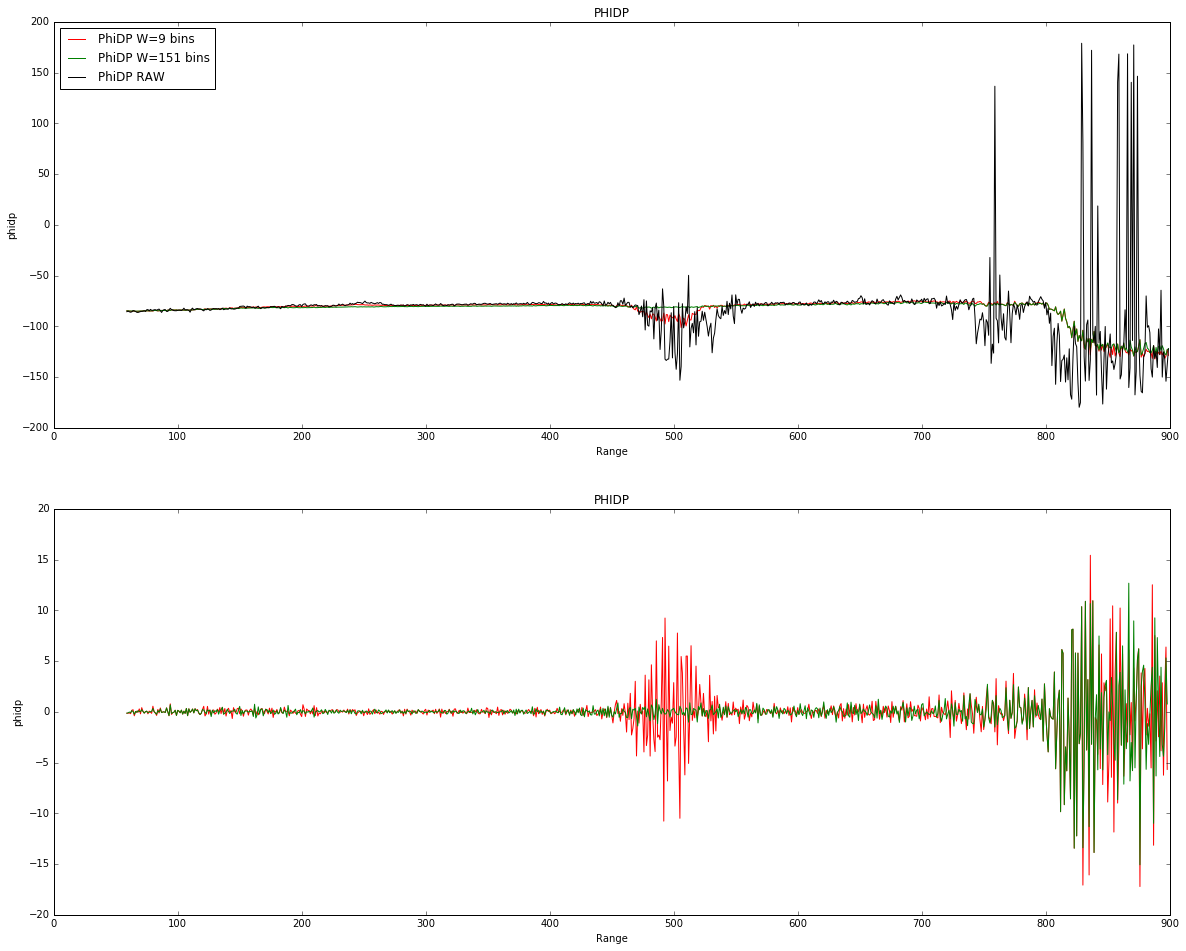

In [26]:
plt.figure(figsize=(20,16))
plt.subplot(2,1,1)
plt.plot(PHIDP3[cut,:], color='red', label='PhiDP W=9 bins')
plt.plot(PHIDP2[cut,:], color='green', label='PhiDP W=151 bins')
plt.plot(phidp[cut,:], color='black', label='PhiDP RAW')
plt.legend(loc='upper left')
plt.title('PHIDP')
plt.xlabel('Range')
plt.ylabel('phidp')
plt.subplot(2,1,2)
plt.plot(np.diff(PHIDP3[cut,:]), color='red')
plt.plot(np.diff(PHIDP2[cut,:]), color='green')
#plt.plot(np.diff(phidp[cut,:]), color='black')

plt.title('PHIDP')
plt.xlabel('Range')
plt.ylabel('phidp')

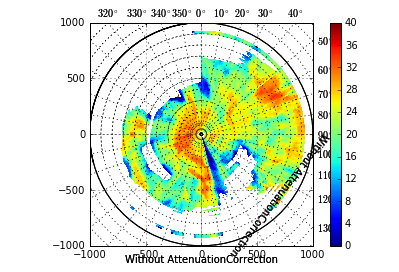

In [17]:
_data = ZH.copy()
_r = np.arange(0, _data.shape[1])
_az = np.arange(0, _data.shape[0])
# mask data array for better presentation
_mask = np.where(_data <= np.nanmin(_data))
_data[_mask] = np.nan
_ma = np.ma.array(_data, mask=np.isnan(_data))
fig = plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(_ma, refrac=False,vmin=0,vmax=40, cg=True, cmap='jet')
#plt.imshow(Z_boxpol)
cb = plt.colorbar(pm, ax=ax)
plt.xlabel('Without AttenuationCorrection')
plt.show()

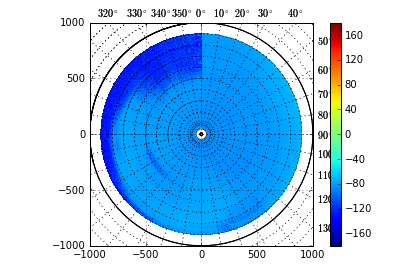

In [18]:
_data = PHIDP.copy()
_r = np.arange(0, _data.shape[1])
_az = np.arange(0, _data.shape[0])
# mask data array for better presentation
_mask = np.where(_data <= np.nanmin(_data))
_data[_mask] = np.nan
_ma = np.ma.array(_data, mask=np.isnan(_data))
fig = plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(_ma, refrac=False,vmin=-180, vmax=180, cg=True, cmap='jet')
#plt.imshow(Z_boxpol)
cb = plt.colorbar(pm, ax=ax)
plt.show()


In [19]:
_data.shape, _r.shape, _az.shape

((360, 1000), (1000,), (360,))

In [29]:
1.**4.3

1.0